<a href="https://colab.research.google.com/github/AlexandreSeb97/CE203N-Spring2021/blob/main/CE203N_Final_Project_Pearl_River.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE 203N Final Project: Flood Prediction in the Gulf of Mexico
###Alexandre Erich Sébastien Georges
###UC Berkeley - Spring 2021
--------------------------------------------------------------------

# Code and Data Setup

### Importing required libraries

In [ ]:
!pip install https://github.com/matplotlib/basemap/archive/master.zip
!pip install wget

import os

import pandas as pd
import matplotlib.pyplot as plt
import math
import wget
import numpy as np
import seaborn as sns
import xarray as xr
from mpl_toolkits.basemap import Basemap
from google.colab import files

# Scikit stuff
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble 
from sklearn.model_selection import GridSearchCV 

#Scikit metrics
from sklearn.metrics import mean_absolute_error, r2_score

     / 149.3MB 1.3MB/s
     |████████████████████████████████| 6.5MB 6.6MB/s 
     |████████████████████████████████| 225kB 37.3MB/s 
  Created wheel for basemap: filename=basemap-1.2.2+dev-cp37-cp37m-linux_x86_64.whl size=121759561 sha256=eaccc4a04b24181c550038b884f9f28dd1525bb635b2ca21030b7074e5c25477
  Stored in directory: /tmp/pip-ephem-wheel-cache-j8bw87hk/wheels/98/4a/fc/ce719b75d97e646645c225f3332b1b217536100314922e9572
  Created wheel for pyshp: filename=pyshp-2.1.3-cp37-none-any.whl size=37264 sha256=51209d91ff33bb194108c1760676b968fd35ba94a139bbbb9afc1f3a672ccfc4
  Stored in directory: /root/.cache/pip/wheels/76/2b/d4/53e6b9a0fb0a9f9f29664cf82605af8bc81d5ab44d987896dd
Successfully built basemap pyshp


  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=38cf5143bd59573990347003986651cb97075220306ffa67add5583637d27791
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


### Downloading streamflow data from USGS Water Services and importing in Dataframe

In [ ]:
stationID = '08065350'
start_date = '1988-05-11'
end_date = '2021-05-02'
filename = 'usgs.txt'
# old = https://nwis.waterdata.usgs.gov/nwis/dv?cb_00060=on&cb_00065=on&cb_00095=on&format=rdb&site_no=08065350&referred_module=sw&period=&begin_date=1985-01-01&end_date=2021-05-02

!wget -O usgs.txt "https://waterdata.usgs.gov/nwis/dv?cb_00045=on&cb_00060=on&cb_00065=on&format=rdb&site_no=02481880&referred_module=sw&period=&begin_date=1980-01-01&end_date=2021-05-02"


--2021-05-06 03:32:02--  https://waterdata.usgs.gov/nwis/dv?cb_00045=on&cb_00060=on&cb_00065=on&format=rdb&site_no=02481880&referred_module=sw&period=&begin_date=1980-01-01&end_date=2021-05-02
Resolving waterdata.usgs.gov (waterdata.usgs.gov)... 137.227.235.122, 137.227.235.123, 137.227.241.67, ...
Connecting to waterdata.usgs.gov (waterdata.usgs.gov)|137.227.235.122|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘usgs.txt’

usgs.txt                [    <=>             ] 580.57K   349KB/s    in 1.7s    

2021-05-06 03:32:05 (349 KB/s) - ‘usgs.txt’ saved [594501]



In [ ]:
df = pd.read_csv(filename, sep='\t', skiprows=31)
stage = 13 # Use site no to pull floodstage on the fly for other sites from https://waterwatch.usgs.gov/index.php?id=flood&sid=w__table&r=tx
trinity = 41
df

,agency_cd,site_no,datetime,163808_00045_00006,163808_00045_00006_cd,78724_00065_00003,78724_00065_00003_cd,78725_00060_00003,78725_00060_00003_cd
0,5s,15s,20d,14n,10s,14n,10s,14n,10s
1,USGS,02481880,1980-12-30,NaN,NaN,NaN,NaN,103,A
2,USGS,02481880,1980-12-31,NaN,NaN,NaN,NaN,101,A
3,USGS,02481880,1981-01-01,NaN,NaN,NaN,NaN,95.0,A
4,USGS,02481880,1981-01-02,NaN,NaN,NaN,NaN,88.0,A
...,...,...,...,...,...,...,...,...,...
14730,USGS,02481880,2021-04-28,0.00,P,11.93,P,1000,P
14731,USGS,02481880,2021-04-29,0.00,P,11.73,P,947,P
14732,USGS,02481880,2021-04-30,0.00,P,11.43,P,867,P
14733,USGS,02481880,2021-05-01,0.00,P,10.88,P,732,P


### Getting NOAA Precipitation Data and importing in Dataframe


In [ ]:
uploaded = files.upload()

Saving climate_pearl.csv to climate_pearl.csv


In [ ]:
filename = 'climate_pearl.csv'
df_prec = pd.read_csv(filename)
df_prec

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES
0,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-01,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",45.0,",,0",32.0,",,0",32.0,",,0,0800",NaN,NaN
1,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-02,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",53.0,",,0",28.0,",,0",30.0,",,0,0800",NaN,NaN
2,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-03,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",58.0,",,0",30.0,",,0",35.0,",,0,0800",NaN,NaN
3,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-04,NaN,NaN,NaN,NaN,0.55,",,0,0800",0.0,",,0",0.0,",,0",56.0,",,0",32.0,",,0",32.0,",,0,0800",NaN,NaN
4,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-05,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",36.0,",,0",26.0,",,0",29.0,",,0,0800",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30746,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-11,NaN,NaN,NaN,NaN,0.22,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30747,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-12,NaN,NaN,NaN,NaN,0.29,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30748,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-13,NaN,NaN,NaN,NaN,0.32,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30749,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-14,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleanup and Merge

### USGS Cleanup 

Renaming Columns and dropping row 0 for easier data manipulation

In [ ]:
df = df.rename(columns={'78725_00060_00003': 'DISCH'})
df = df.rename(columns={'78724_00065_00003': 'GAGE'})
df = df.drop(0)
df

,agency_cd,site_no,datetime,163808_00045_00006,163808_00045_00006_cd,GAGE,78724_00065_00003_cd,DISCH,78725_00060_00003_cd
1,USGS,02481880,1980-12-30,NaN,NaN,NaN,NaN,103,A
2,USGS,02481880,1980-12-31,NaN,NaN,NaN,NaN,101,A
3,USGS,02481880,1981-01-01,NaN,NaN,NaN,NaN,95.0,A
4,USGS,02481880,1981-01-02,NaN,NaN,NaN,NaN,88.0,A
5,USGS,02481880,1981-01-03,NaN,NaN,NaN,NaN,82.0,A
...,...,...,...,...,...,...,...,...,...
14730,USGS,02481880,2021-04-28,0.00,P,11.93,P,1000,P
14731,USGS,02481880,2021-04-29,0.00,P,11.73,P,947,P
14732,USGS,02481880,2021-04-30,0.00,P,11.43,P,867,P
14733,USGS,02481880,2021-05-01,0.00,P,10.88,P,732,P


Changing object types to int, float, str and datetime

In [ ]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['GAGE'] = df['GAGE'].replace(['Ice'], [0])
df['GAGE'] = df['GAGE'].astype(float)
df['DISCH'] = df['DISCH'].replace(['Ice'], [0])
df['DISCH'] = df['DISCH'].astype(float)
#df['DISCHMAX'] = df['DISCHMAX'].astype(float)
#df['DISCHMIN'] = df['DISCHMIN'].astype(float)
df.dtypes

agency_cd                        object
site_no                          object
datetime                 datetime64[ns]
163808_00045_00006               object
163808_00045_00006_cd            object
GAGE                            float64
78724_00065_00003_cd             object
DISCH                           float64
78725_00060_00003_cd             object
dtype: object

### NOAA Cleanup

Renaming DATE column to datetime

In [ ]:
df_prec = df_prec.rename(columns={'DATE': 'datetime'})
df_prec

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,datetime,DAPR,DAPR_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WESD,WESD_ATTRIBUTES
0,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-01,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",45.0,",,0",32.0,",,0",32.0,",,0,0800",NaN,NaN
1,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-02,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",53.0,",,0",28.0,",,0",30.0,",,0,0800",NaN,NaN
2,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-03,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",58.0,",,0",30.0,",,0",35.0,",,0,0800",NaN,NaN
3,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-04,NaN,NaN,NaN,NaN,0.55,",,0,0800",0.0,",,0",0.0,",,0",56.0,",,0",32.0,",,0",32.0,",,0,0800",NaN,NaN
4,USC00225247,"LOUISVILLE, MS US",33.13550,-89.07110,177.1,1980-01-05,NaN,NaN,NaN,NaN,0.00,",,0,0800",0.0,",,0",0.0,",,0",36.0,",,0",26.0,",,0",29.0,",,0,0800",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30746,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-11,NaN,NaN,NaN,NaN,0.22,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30747,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-12,NaN,NaN,NaN,NaN,0.29,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30748,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-13,NaN,NaN,NaN,NaN,0.32,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30749,US1MSWN0002,"NOXAPATER 3.3 WSW, MS US",32.97507,-89.11696,145.1,2021-02-14,NaN,NaN,NaN,NaN,0.00,",,N",0.0,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Changing object types to datetime

In [ ]:
df_prec['datetime'] = pd.to_datetime(df_prec['datetime'], errors='coerce')

### Merging NOAA and USGS on time and dropping unnecessary columns

In [ ]:
newdf = df.merge(df_prec)

to_rem = list(newdf)
exception = ['datetime', 'GAGE', 'DISCH', 'PRCP', 'SNOW', 'TMIN', 'TMAX', 'NAME', 'STATION', 'site_no']
for k in exception:
  #print(k)
  to_rem.remove(k)

newdf = newdf.drop(to_rem, axis=1)
newdf['SNOW'] = newdf['SNOW'].fillna(0)
newdf

,site_no,datetime,GAGE,DISCH,STATION,NAME,PRCP,SNOW,TMAX,TMIN
0,02481880,1980-12-30,NaN,103.0,USC00225247,"LOUISVILLE, MS US",0.00,0.0,61.0,33.0
1,02481880,1980-12-30,NaN,103.0,USC00223340,"GHOLSON 8 W, MS US",0.00,0.0,NaN,NaN
2,02481880,1980-12-31,NaN,101.0,USC00225247,"LOUISVILLE, MS US",0.00,0.0,48.0,28.0
3,02481880,1980-12-31,NaN,101.0,USC00223340,"GHOLSON 8 W, MS US",0.00,0.0,NaN,NaN
4,02481880,1981-01-01,NaN,95.0,USC00225247,"LOUISVILLE, MS US",0.00,0.0,63.0,35.0
...,...,...,...,...,...,...,...,...,...,...
30018,02481880,2021-04-26,11.93,1000.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN
30019,02481880,2021-04-27,12.25,1100.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN
30020,02481880,2021-04-28,11.93,1000.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN
30021,02481880,2021-04-29,11.73,947.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN


Pullin training and testing sets and adding DAY_OF_YEAR for seasonality analysis

In [ ]:
newdf['DAY_OF_YEAR'] = newdf['datetime'].dt.dayofyear
train_df = newdf[newdf['datetime'].dt.year <= 2014]
test_df = newdf[newdf['datetime'].dt.year > 2014]
newdf

,site_no,datetime,GAGE,DISCH,STATION,NAME,PRCP,SNOW,TMAX,TMIN,DAY_OF_YEAR
0,02481880,1980-12-30,NaN,103.0,USC00225247,"LOUISVILLE, MS US",0.00,0.0,61.0,33.0,365
1,02481880,1980-12-30,NaN,103.0,USC00223340,"GHOLSON 8 W, MS US",0.00,0.0,NaN,NaN,365
2,02481880,1980-12-31,NaN,101.0,USC00225247,"LOUISVILLE, MS US",0.00,0.0,48.0,28.0,366
3,02481880,1980-12-31,NaN,101.0,USC00223340,"GHOLSON 8 W, MS US",0.00,0.0,NaN,NaN,366
4,02481880,1981-01-01,NaN,95.0,USC00225247,"LOUISVILLE, MS US",0.00,0.0,63.0,35.0,1
...,...,...,...,...,...,...,...,...,...,...,...
30018,02481880,2021-04-26,11.93,1000.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN,116
30019,02481880,2021-04-27,12.25,1100.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN,117
30020,02481880,2021-04-28,11.93,1000.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN,118
30021,02481880,2021-04-29,11.73,947.0,US1MSWN0009,"LOUISVILLE 8.6 SSE, MS US",0.00,0.0,NaN,NaN,119


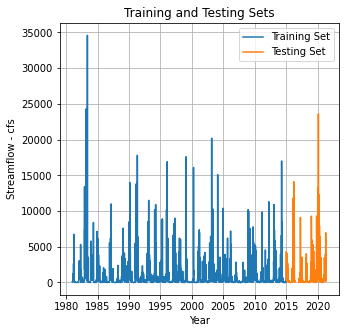

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(train_df['datetime'], train_df['DISCH'], label='Training Set')
ax.plot(test_df['datetime'], test_df['DISCH'], label='Testing Set')

ax.set(xlabel='Year',
       ylabel='Streamflow - cfs',
       title='Training and Testing Sets')
ax.legend()
plt.grid()
plt.show()

## Data Visualization

### Visualizing USGS Data

Setting Datetime as Index


In [ ]:
newdf = newdf.set_index('datetime')
train_df = train_df.set_index('datetime')
test_df = test_df.set_index('datetime')

#### Gage Height Timeseries

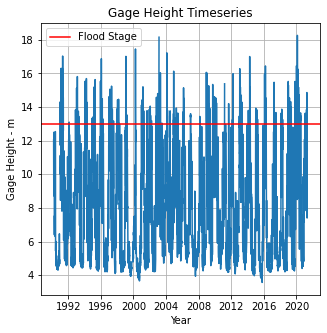

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(newdf.index.values, newdf['GAGE'])
plt.axhline(y = stage, color = 'r', linestyle = '-', label='Flood Stage')

ax.set(xlabel='Year',
       ylabel='Gage Height - m',
       title='Gage Height Timeseries')
ax.legend()
plt.grid()
plt.show()

#### Discharge Timeseries

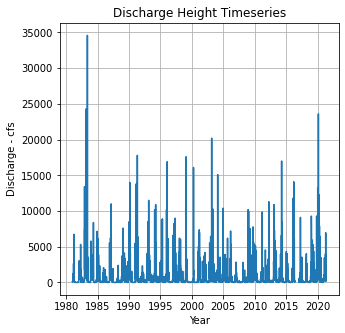

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(newdf.index.values, newdf['DISCH'])
#plt.fill_between(newdf.index.values, newdf['DISCHMIN'], newdf['DISCHMAX'],
                # color='gray', alpha=0.7)

ax.set(xlabel='Year',
       ylabel='Discharge - cfs',
       title='Discharge Height Timeseries')
plt.grid()
plt.show()

#### Precipitation Timeseries

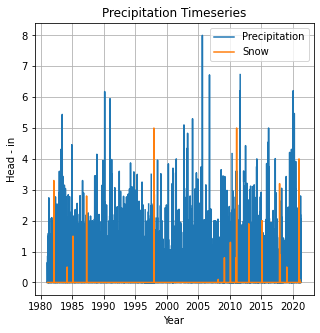

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(newdf.index.values, newdf['PRCP'], label='Precipitation')
ax.plot(newdf.index.values, newdf['SNOW'], label='Snow')

ax.set(xlabel='Year',
       ylabel='Head - in',
       title='Precipitation Timeseries')
ax.legend()
plt.grid()
plt.show()

# Model Training and Height Prediction

In [ ]:
mean = newdf['DISCH'].mean()
mean

642.1571567032684

Evaluating Visualization

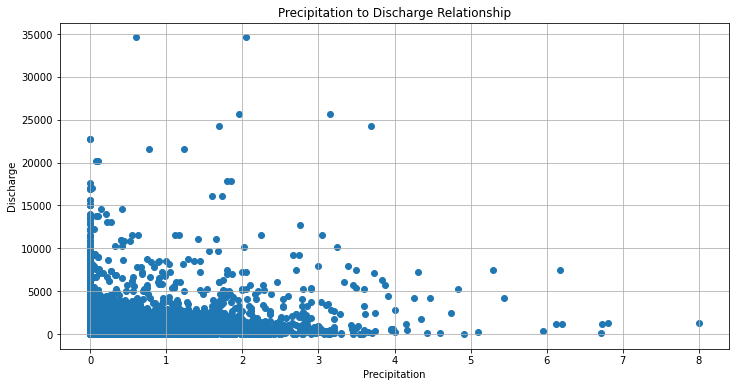

In [ ]:
features = ['PRCP', 'DAY_OF_YEAR', 'SNOW', 'TMAX', 'TMIN']
target = 'DISCH'

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(train_df['PRCP'], 
           train_df['DISCH'],)
ax.set(xlabel='Precipitation',
       ylabel='Discharge',
       title="Precipitation to Discharge Relationship")
plt.grid()
plt.show()

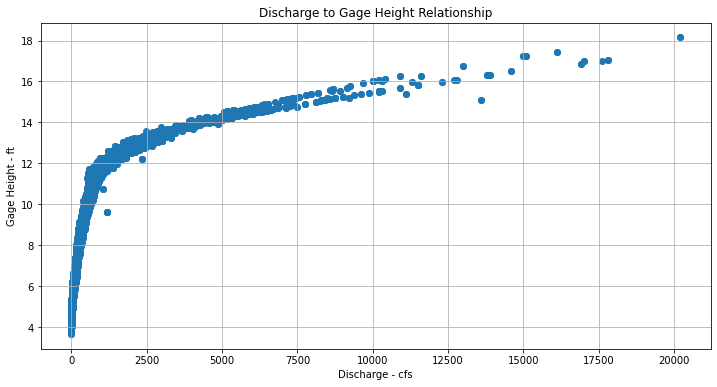

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(train_df['DISCH'], 
           train_df['GAGE'],)
ax.set(xlabel='Discharge - cfs',
       ylabel='Gage Height - ft',
       title="Discharge to Gage Height Relationship")
plt.grid()
plt.show()

## Linear Regression

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()

x_train = train_df[features]
y_train = train_df[target]

x_gage_tr = train_df['DISCH']
y_gage_tr = train_df['GAGE']

x_test = test_df[features]
y_test = test_df[target]

x_gtest = test_df['DISCH']
y_gtest = test_df['GAGE']




In [ ]:
x_test = imputer.fit_transform(x_test)
x_train = imputer.fit_transform(x_train)
y_test  = (y_test.values).reshape(len(y_test), 1)
y_test = imputer.fit_transform(y_test)

x_gage_tr  = (x_gage_tr.values).reshape(len(x_gage_tr), 1)
y_gage_tr  = (y_gage_tr.values).reshape(len(y_gage_tr), 1)
x_gtest  = (x_gtest.values).reshape(len(x_gtest), 1)

x_gage_tr = imputer.fit_transform(x_gage_tr)
y_gage_tr = imputer.fit_transform(y_gage_tr)
x_gtest = imputer.fit_transform(x_gtest)
#x_train[np.isnan(x_train)] = np.median(x_train[~np.isnan(x_train)]) 
#x_test[np.isnan(x_test)] = np.median(x_test[~np.isnan(x_test)])
#x_test.dropna(how='all')
#x_test = x_test.reset_index(drop=True)

#y_train[np.isnan(y_train)] = np.median(y_train[~np.isnan(y_train)])
#y_test[np.isnan(y_test)] = np.median(y_test[~np.isnan(y_test)])
#print(np.isnan(x_test).any())
#x_train

In [ ]:
x_test.shape

(4122, 5)

In [ ]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
prediction = linear_model.predict(x_test)

In [ ]:
mae_linear = mean_absolute_error(y_test, prediction)
r2_linear = r2_score(y_test, prediction)

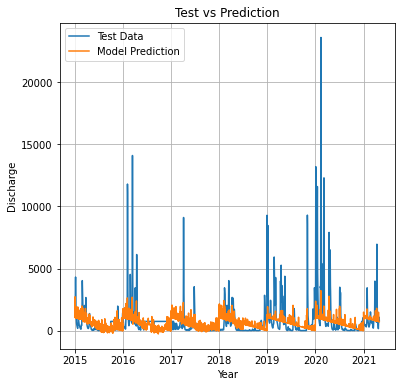

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(test_df.index.values, y_test, label='Test Data')
ax.plot(test_df.index.values, prediction, label='Model Prediction')
ax.set(xlabel='Year',
       ylabel='Discharge',
       title='Test vs Prediction')
plt.legend()
plt.grid()
plt.show()

##Polynomial Regression

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

poly_model = PolynomialRegression(2)
poly_model.fit(x_train, y_train)
poly_predic = poly_model.predict(x_test)

In [ ]:
mae_poly = mean_absolute_error(y_test, poly_predic)
r2_poly = r2_score(y_test, poly_predic)

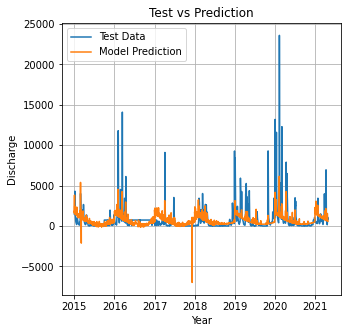

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))

ax.plot(test_df.index.values, y_test, label='Test Data')
ax.plot(test_df.index.values, poly_predic, label='Model Prediction')
ax.set(xlabel='Year',
       ylabel='Discharge',
       title='Test vs Prediction')
plt.legend()
plt.grid()
plt.show()

## Random Forest

In [ ]:
sc = StandardScaler()
x_train_sc = sc.fit_transform(x_train)
x_test_sc = sc.transform(x_test)

Some Hyperparameter Tuning using GridSearch

In [ ]:
from sklearn.model_selection import cross_val_score
model = ensemble.RandomForestRegressor()
parameters = [{'n_estimators':[100, 250, 750],
              'max_depth':[2.5, 5,10,25],
              'random_state':[5,10,25, 50]}]
grid_search = GridSearchCV(estimator=model, param_grid=parameters, cv=10, n_jobs=-1)
grid = grid_search.fit(x_train, y_train)
grid.best_score_

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.10494428548842039

In [ ]:
grid.best_params_

{'max_depth': 5, 'n_estimators': 100, 'random_state': 10}

In [ ]:
regressor = RandomForestRegressor(n_estimators=1000, random_state=75, max_depth=50, min_samples_leaf=5)
regressor.fit(x_train_sc, y_train)
random_predic = regressor.predict(x_test_sc)

In [ ]:
mae_random_forest = mean_absolute_error(y_test, random_predic)
r2_random_forest = r2_score(y_test, random_predic)

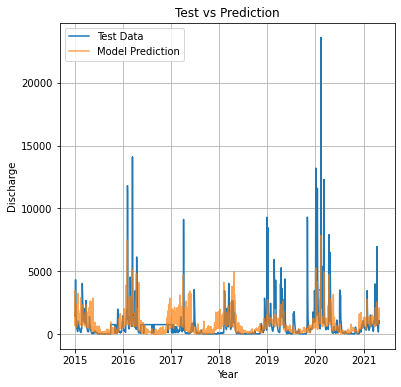

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(test_df.index.values, y_test, label='Test Data')
ax.plot(test_df.index.values, random_predic, label='Model Prediction', alpha=0.7)
ax.set(xlabel='Year',
       ylabel='Discharge',
       title='Test vs Prediction')
plt.legend()
plt.grid()
plt.show()

In [ ]:
regressor = RandomForestRegressor(n_estimators=1000, random_state=75, max_depth=50, min_samples_leaf=5)
regressor.fit(x_gage_tr, y_gage_tr)
random_predic  = (random_predic).reshape(len(random_predic), 1)
gage_predic = regressor.predict(random_predic)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


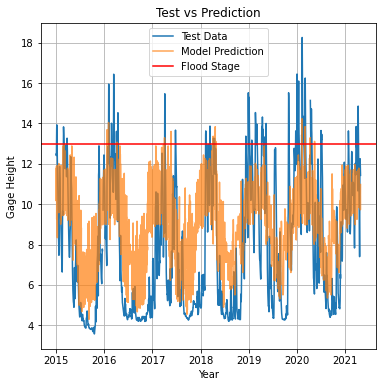

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

ax.plot(test_df.index.values, y_gtest, label='Test Data')
ax.plot(test_df.index.values, gage_predic, label='Model Prediction', alpha=0.7)
plt.axhline(y = stage, color = 'r', linestyle = '-', label='Flood Stage')
ax.set(xlabel='Year',
       ylabel='Gage Height',
       title='Test vs Prediction')
plt.legend()
plt.grid()
plt.show()

## Validation and Scoring

In [ ]:
model_validation = {'Model Type': ['Linear Regression', 'Polynomial Regression (3)', 'Random Forest'], 
                       'MAE': [mae_linear, mae_poly, mae_random_forest], 
                       'R^2':[r2_linear, r2_poly, r2_random_forest]}

validation_df = pd.DataFrame(model_validation)
validation_df

,Model Type,MAE,R^2
0,Linear Regression,678.522878,0.082379
1,Polynomial Regression (3),661.002618,0.126096
2,Random Forest,647.423986,0.108093
